# 2020 annual CDC survey data of 400k adults related to their health status


## Description

Originally, the dataset come from the CDC and is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents. As the CDC describes: "Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.". The most recent dataset (as of February 15, 2022) includes data from 2020. It consists of 401,958 rows and 279 columns. The vast majority of columns are questions asked to respondents about their health status, such as "Do you have serious difficulty walking or climbing stairs?" or "Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]". In this dataset, I noticed many different factors (questions) that directly or indirectly influence heart disease, so I decided to select the most relevant variables from it and do some cleaning so that it would be usable for machine learning projects.


## **Link** 
https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

In [82]:
#Necessary Imports and File Reading
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

df = pd.read_csv(r"heart_2020_cleaned.csv")

# Initial View of the Dataset

A good first practice would be to look at the types of our variables and how they are distributed (if applicable). 
We can do this below simply enough with Pandas' describe and info methods for DataFrames!

In [86]:
display(df.head(5))

display(df.info())

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

None

**Great, no null values! Lets observe our variables of type 'float' using describe.**

 A few interesting notes follow...
* Is a BMI of 94 possible? 
    * Yes. There are records of 100+ BMI recorded. I had to look this up because I had never heard of a BMI that high..
* The physical & mental health variables are interesting. They appear to be extremely right skewed initially.
* The max of SleepTime seems incorrect. How can someone sleep for what I assume is on average, for 24 hours?

In [87]:
display(df.describe())

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


# Quickly checking the unique values of our categorical variables

When first looking at a dataset with categorical variables, it is best not to assume the "form" of your data. What if there are typos, capitalization differences, or other minor issues you did not anticipate?

A useful data cleaning skill is being able to neatly check the unique values of your categorical values in a small function. Below is a quick way that came to mind when I first wanted to understand if there were any typos or other issues with the dataset. Some useful insights are detailed below:

- We have a mix of binary, ordinal, and categorical variables. Recognizing this early on can help plan how we handle these variables in an algorithm such as logistic regression
- For a beginner data cleaning technique, we can convert binary variables and rename the variables for the sake of clarity
- One plus to this dataset is that it does not need much cleaning.
- Additionally, we can see that our diabetic column has a few unique values that could reasonably be converted for clarity sake. While this variable would have seemed binary on initial inspection, the "borderline diabetes" and "during pregnancy" additions could make this a categorical variable.
    - It will be useful to compare how our future model will perform based on how we classify/code this variable.


In [90]:
def ShowObjectVars(df):
    
    types = df.dtypes
    type_dict = {}
    for i in types.index:
        if types[i] == 'object':
            type_dict[i] = list(np.unique(df[i].values))
    
    return type_dict 

ShowObjectVars(df)

{'HeartDisease': ['No', 'Yes'],
 'Smoking': ['No', 'Yes'],
 'AlcoholDrinking': ['No', 'Yes'],
 'Stroke': ['No', 'Yes'],
 'DiffWalking': ['No', 'Yes'],
 'Sex': ['Female', 'Male'],
 'AgeCategory': ['18-24',
  '25-29',
  '30-34',
  '35-39',
  '40-44',
  '45-49',
  '50-54',
  '55-59',
  '60-64',
  '65-69',
  '70-74',
  '75-79',
  '80 or older'],
 'Race': ['American Indian/Alaskan Native',
  'Asian',
  'Black',
  'Hispanic',
  'Other',
  'White'],
 'Diabetic': ['No',
  'No, borderline diabetes',
  'Yes',
  'Yes (during pregnancy)'],
 'PhysicalActivity': ['No', 'Yes'],
 'GenHealth': ['Excellent', 'Fair', 'Good', 'Poor', 'Very good'],
 'Asthma': ['No', 'Yes'],
 'KidneyDisease': ['No', 'Yes'],
 'SkinCancer': ['No', 'Yes']}

In [91]:
def ConvertDiabetic(df):
    new_df = df.copy()
    
    app_dict = {'No':'no',
                'No, borderline diabetes':'borderline',
                'Yes':'yes',
                'Yes (during pregnancy)':'yes during pregnancy'}
    new_df['Diabetic'] = new_df['Diabetic'].apply(lambda x: app_dict[x])
    
    return new_df

convert_df = ConvertDiabetic(df)

print(np.unique(convert_df['Diabetic'].values))

['borderline' 'no' 'yes' 'yes during pregnancy']


In [92]:
def ConvertBinary(df):
    
    new_df = df.copy()
    
    types = df.dtypes
    type_dict = {}
    for i in types.index:
        if types[i] == 'object':
            unique_vals = list(np.unique(new_df[i].values))
            if 'Yes' in unique_vals:
                new_df[i] = new_df[i].apply(lambda x: 1 if x == 'Yes' else 0)
            elif 'Male' in unique_vals:
                new_df[i] = new_df[i].apply(lambda x: 1 if x == 'Male' else 0)
            else:
                pass
    return new_df
            
new_conv = ConvertBinary(convert_df)
display(new_conv.head(5))

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,55-59,White,yes,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80 or older,White,no,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,65-69,White,yes,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,75-79,White,no,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,40-44,White,no,1,Very good,8.0,0,0,0


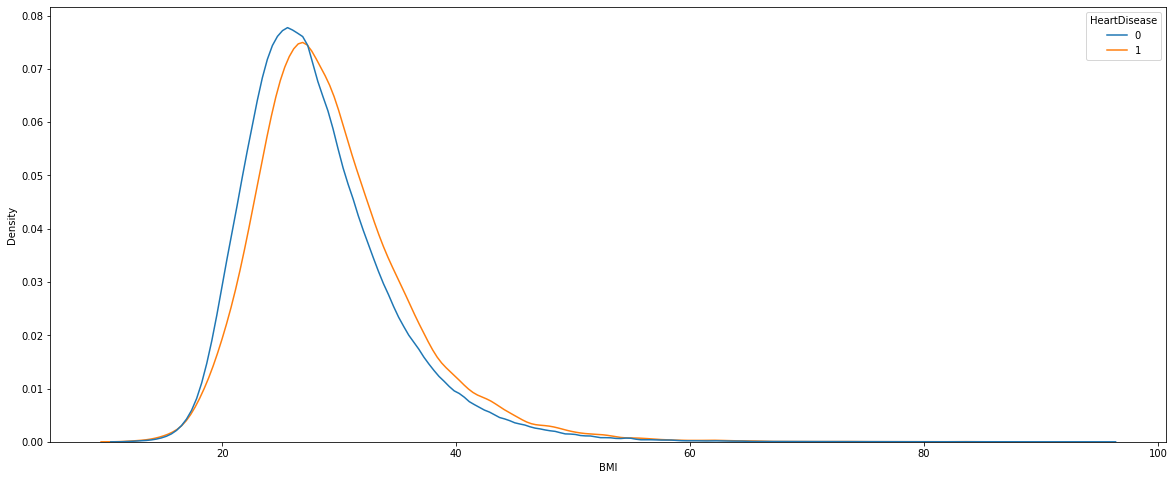

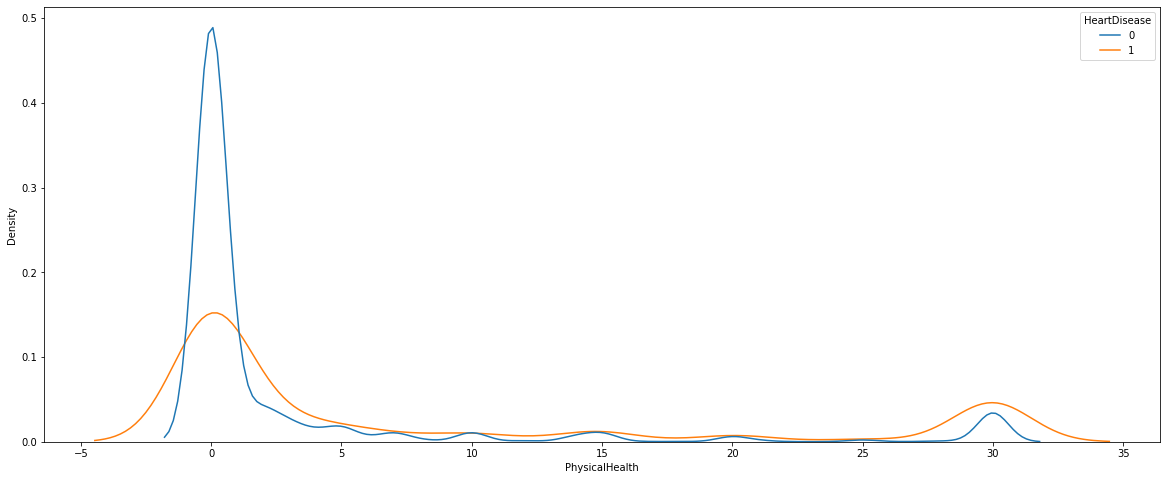

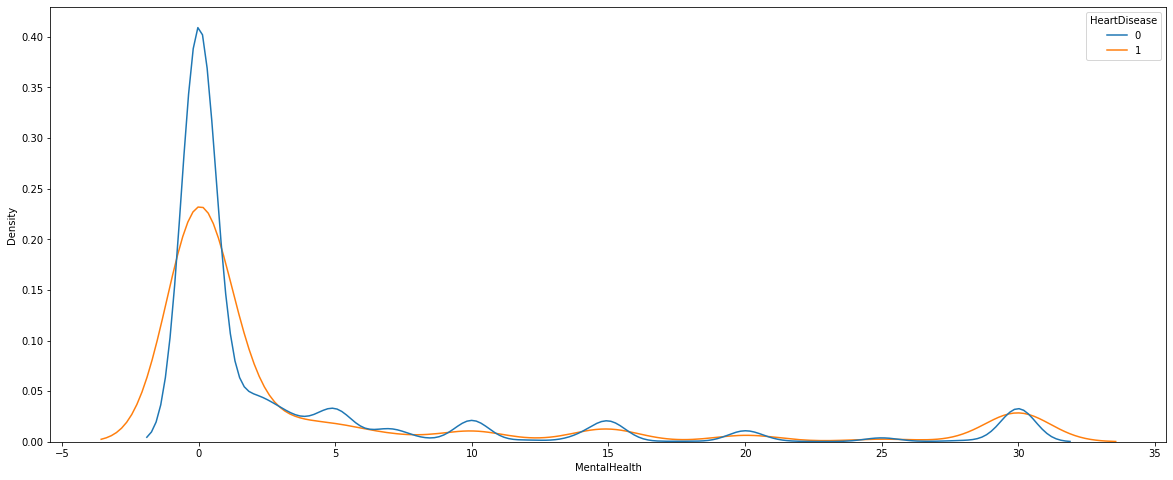

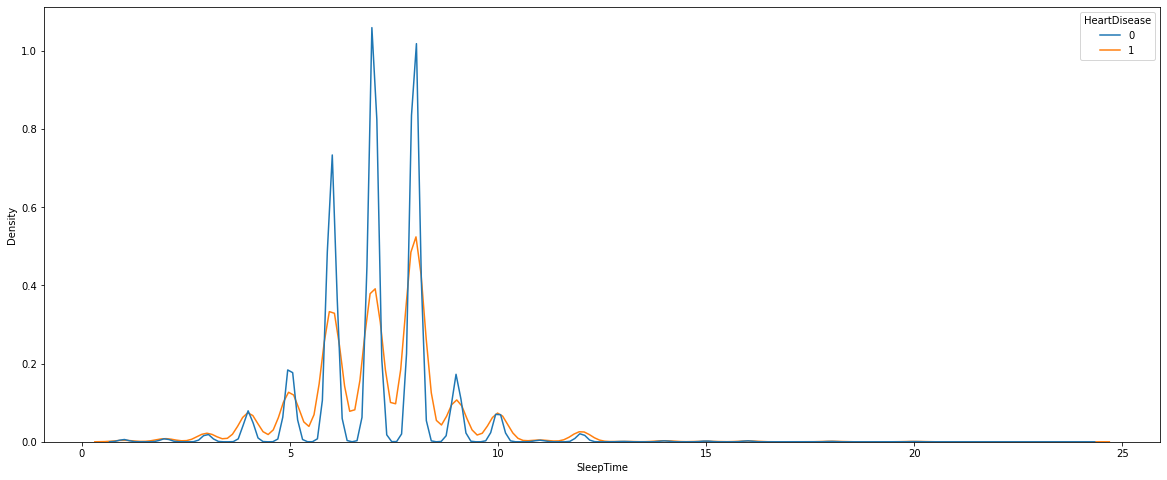

In [75]:
#Lets look at the distributions of our float variables and compare them between the two classes of HeartDisease

plt.rcParams['figure.figsize'] = [20, 8]


for name in ['BMI','PhysicalHealth','MentalHealth','SleepTime']:
    sns.kdeplot(data=new_conv, x=name, hue="HeartDisease",common_norm = False)
    plt.show()
    plt.close()


# Takeaways

# 1) Distributions are normalized based on size of the dataset they were made from.
# This is an unbalanced classification problem.
# 2) The BMI distribution for those with heart disease havers is shifted right relative to "No". Can we use this?
# 3) The two datasets share very similar peak locations but with differences in spread. Can we use the spread
# or variation to our advantage?

<AxesSubplot:>

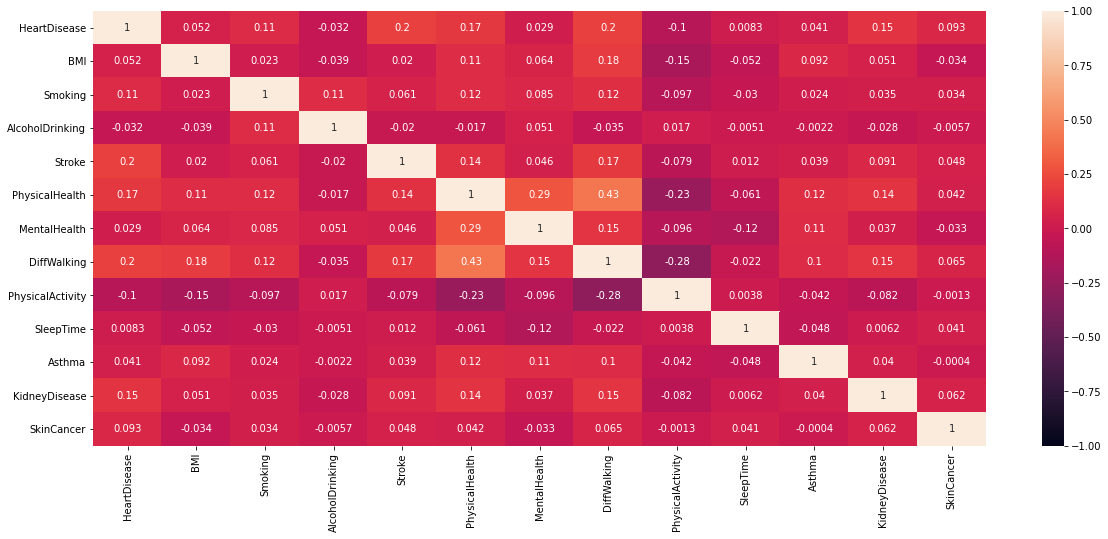

In [80]:
#Understanding correlations. What information can we learn from the correlations?

corr_mat = new_conv.corr()

sns.heatmap(corr_mat,annot = True,vmin = -1,vmax = 1)

# The strongest correlations observed are between 
# interactions of the PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity variables.
# MOst of these results are mostly unsurprising and reasonable.